In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df=pd.read_csv('mitbih_train.csv',header=None)
test_df=pd.read_csv('mitbih_test.csv',header=None)

In [3]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


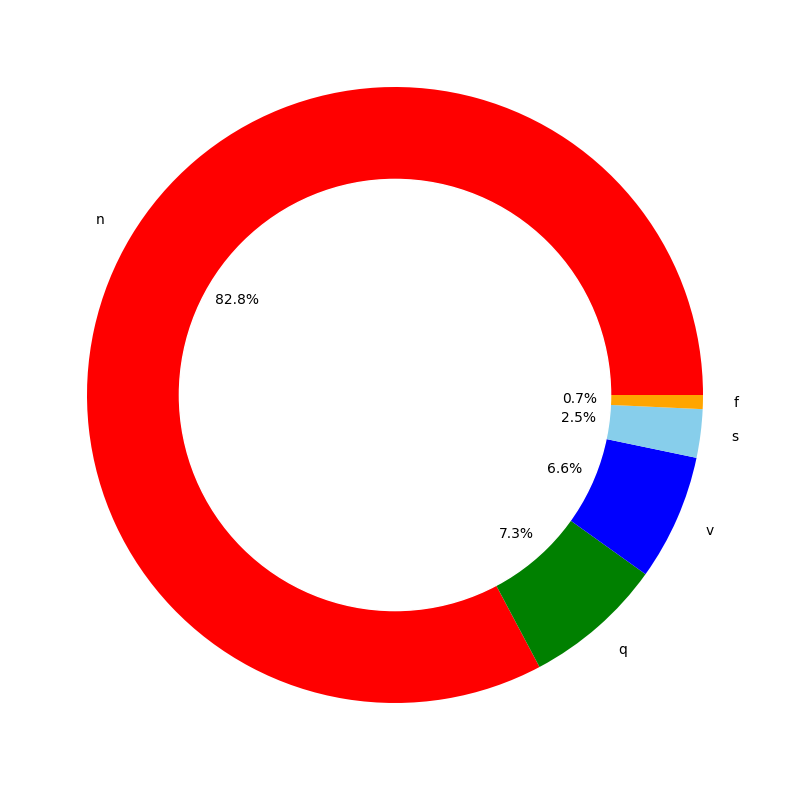

In [5]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
# -N : Non-ecotic beats (normal beat) -S : Supraventricular ectopic beats -V : Ventricular ectopic beats -F : Fusion Beats -Q : Unknown Beats

In [6]:
# lets look at all the classes
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
c

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
84,1.000000,0.875465,0.498141,0.358736,0.351301,0.291822,0.256506,0.217472,0.184015,0.139405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
74491,0.977564,0.480769,0.259615,0.150641,0.089744,0.099359,0.067308,0.064103,0.067308,0.080128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
79975,1.000000,0.931818,0.687063,0.445804,0.213287,0.080420,0.094406,0.073427,0.061189,0.076923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80779,1.000000,0.933594,0.725260,0.425781,0.174479,0.145833,0.147135,0.122396,0.106771,0.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
85618,0.809420,0.719606,0.622125,0.537787,0.446878,0.355969,0.274918,0.178532,0.099671,0.062432,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [7]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [8]:
## add alittle gaussian noise 
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.2,186)
    return (signal+noise)

In [9]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [10]:
# imports 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution1D, MaxPool1D, BatchNormalization, Input, LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from attention import Attention



def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    hidden1 = LSTM(32)(pool3)
    # flatten=Flatten()(pool3)
    dense_end1 = Dense(32, activation='relu')(hidden1)
    dense_end2 = Dense(16, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    
    return model, callbacks

    

In [11]:
model, callbacks = network(X_train,y_train,X_test,y_test) 

In [12]:
model.summary(line_length = 300)

Model: "model"
____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                                                                          Output Shape                                                                                                            Param #                                      
 inputs_cnn (InputLayer)                                                                                                               [(None, 186, 1)]                                                                                                        0                                            
                                                                                  

In [13]:
history=model.fit(X_train, y_train,epochs=15,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))

Epoch 1/15
2737/2737 [==============================] - 56s 19ms/step - loss: 0.3795 - accuracy: 0.8929 - val_loss: 0.2407 - val_accuracy: 0.9347
Epoch 2/15
2737/2737 [==============================] - 52s 19ms/step - loss: 0.2567 - accuracy: 0.9265 - val_loss: 0.2139 - val_accuracy: 0.9460
Epoch 3/15
2737/2737 [==============================] - 52s 19ms/step - loss: 0.2208 - accuracy: 0.9351 - val_loss: 0.1723 - val_accuracy: 0.9505
Epoch 4/15
2737/2737 [==============================] - 51s 19ms/step - loss: 0.2013 - accuracy: 0.9421 - val_loss: 0.1639 - val_accuracy: 0.9536
Epoch 5/15
2737/2737 [==============================] - 51s 19ms/step - loss: 0.1863 - accuracy: 0.9464 - val_loss: 0.1472 - val_accuracy: 0.9625
Epoch 6/15
2737/2737 [==============================] - 53s 19ms/step - loss: 0.1742 - accuracy: 0.9497 - val_loss: 0.1397 - val_accuracy: 0.9652
Epoch 7/15
2737/2737 [==============================] - 51s 19ms/step - loss: 0.1662 - accuracy: 0.9523 - val_loss: 0.1546 -

In [14]:
from sklearn.metrics import precision_recall_fscore_support as score
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    # print(list(prediction))
    # print(list(y_true))
    cnf_matrix = confusion_matrix(y_true, prediction)
    precision, recall, fscore, support = score(list(y_true), list(prediction))

    print('precision: {}'.format(precision))
    print('recall:    {}'.format(recall))
    print('fscore:    {}'.format(fscore))

Accuracy: 96.05%


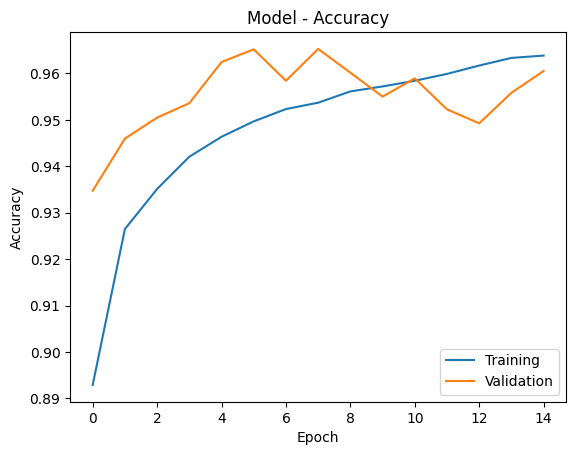

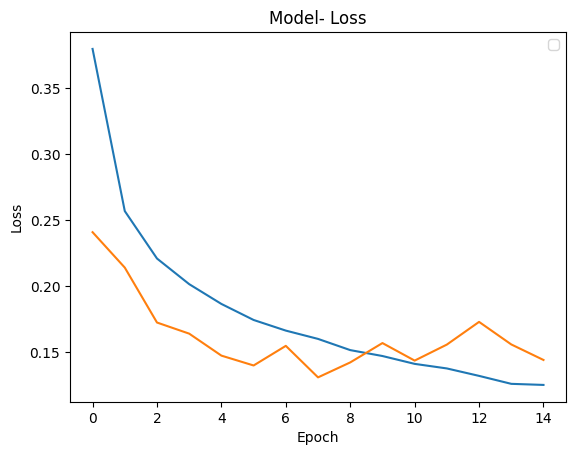

685/685 [==============================] - 4s 5ms/step
precision: [0.96473174 0.86461538 0.9446672  0.65248227 0.97109067]
recall:    [0.99343195 0.50539568 0.81353591 0.56790123 0.91915423]
fscore:    [0.97887152 0.63791146 0.8742115  0.60726073 0.94440895]


In [15]:
evaluate_model(history,X_test,y_test,model)
# 


685/685 [==============================] - 4s 6ms/step
Normalized confusion matrix


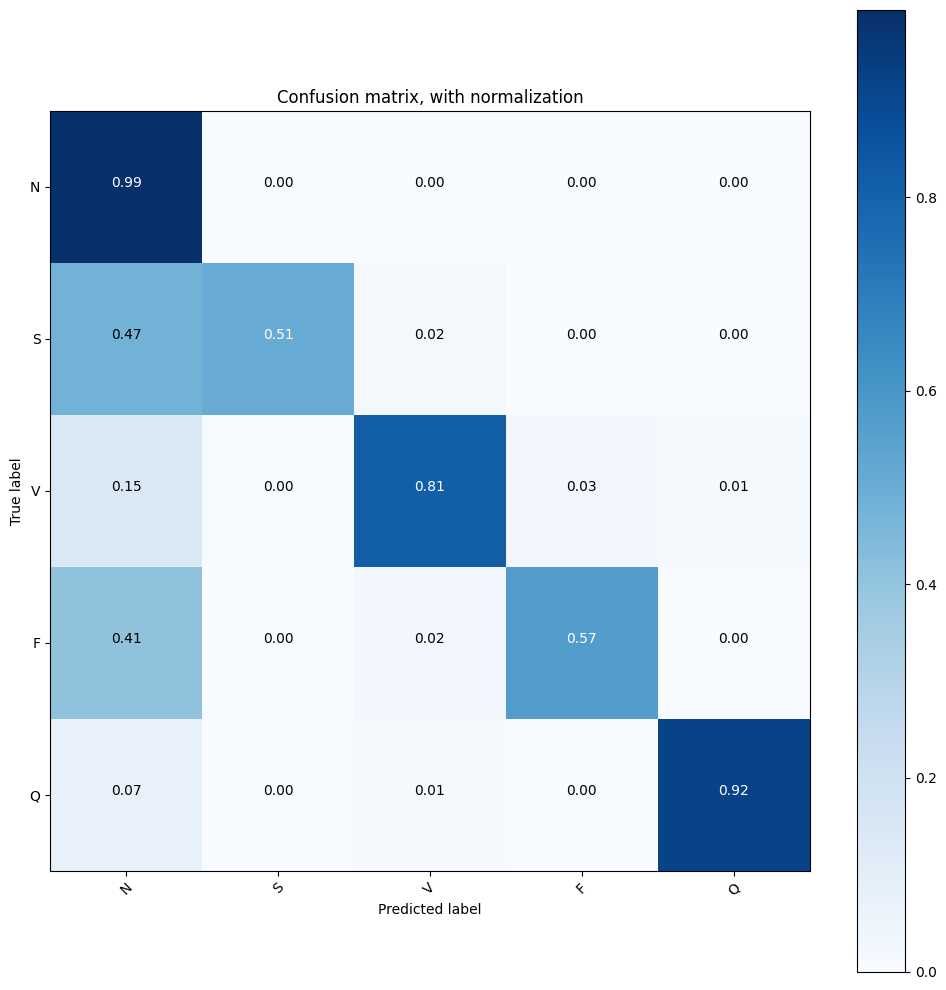

In [17]:
import itertools
y_pred=model.predict(X_test)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()